# Moving Barrier: Gradually Vanishing Walls
In this experiment, we initially have three walls that prohibits the mass to go thourgh and each wall gradually vanishes. The first wall vanishes after 5 steps, the second vanishes in 10, and the third vanishes after 15.

Considering the previous experiment, we use $\delta=100$. (I tried $\delta=10$, but in this example, there were too much "mass leak" even with $\delta=10$)

This experiment is labeled "PARTIAL" because as we see in the following, the violation of the continuity equation is much higher than in other cases.

# Set up


In [21]:
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
import sys
from PIL import Image
sys.path.append('../../..')
from proximal.grids import speed_and_growth
from proximal.dynamicUOT import computeGeodesic
import ipywidgets as widgets
from ipywidgets import interact

def image_to_numpy(image_path):
    # Load the image file
    image = Image.open(image_path).convert('L')  # Convert image to grayscale if it's not

    # Convert the PIL image to a numpy array
    image_array = np.array(image)

    return image_array

maze3 = (1-image_to_numpy('data/input/maze3.png').squeeze()/255)

# Moving barrier generator. This is specific to maze.png.
def fill_region(frames, fps, speed, original, Hstep):
    rows, cols = 30, 30
    step_size = speed*14/fps

    # Define the region to fill
    start_col, end_col = 1, 14

    # Create a list to store each frame
    filled_frames = [original]

    for i in range(1,frames):
        frame = filled_frames[-1].copy()
        # Determine the slice to fill based on speed
        end_fill = max(1, int(end_col - i*step_size))
        frame[18:20, end_fill:14] += Hstep
        # if above 1, clip to 1
        frame[frame > 1.0] = 1.0
        
        # Append the current state of the array to the list
        filled_frames.append(frame.copy())
    
    return filled_frames

def vanishing_walls(frames, maze, Hstep):
    # Create an initial frame
    maze_with_walls = maze.copy()
    maze_with_walls[1:29, 14:16] = Hstep*5
    maze_with_walls[1:29, 28:30] = Hstep*10
    maze_with_walls[1:29, 43:45] = Hstep*15
    filled_frames = [maze_with_walls]
    for i in range(1,frames):
        frame = filled_frames[-1].copy()
        frame[1:29, 14:16] -= Hstep
        frame[1:29, 28:30] -= Hstep
        frame[1:29, 43:45] -= Hstep
        frame[frame < 0] = 0
        filled_frames.append(frame.copy())
    return filled_frames

def plot_frames(t, frames):
    plt.figure(figsize=(2,2))
    plt.imshow(frames[t])
    plt.tight_layout()
    plt.show()

T = 30
frames = vanishing_walls(T, maze3, Hstep=0.01)
interact(lambda t: plot_frames(t, frames), t=widgets.IntSlider(min=0, max=T-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=29), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(t)>

<>:78: SyntaxWarning: invalid escape sequence '\s'
<>:82: SyntaxWarning: invalid escape sequence '\i'
<>:78: SyntaxWarning: invalid escape sequence '\s'
<>:82: SyntaxWarning: invalid escape sequence '\i'
C:\Users\mao17\AppData\Local\Temp\ipykernel_18500\2215481413.py:78: SyntaxWarning: invalid escape sequence '\s'
  plt.title("$\sum_{t}|\int_{\Omega}H(t,x)d\\rho_t(x)-F(t)|$ at each iteration")
C:\Users\mao17\AppData\Local\Temp\ipykernel_18500\2215481413.py:82: SyntaxWarning: invalid escape sequence '\i'
  plt.title("$|\int_{\Omega}H(t,x)d\\rho_t(x)-F(t)|$ at each t for the final solution")


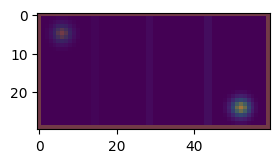

In [22]:
# We will use the following parameters for this constraint
T = 30
N1 = maze3.shape[0]
N2 = maze3.shape[1]
F = np.zeros((T,))

dx = [1.0/N1, 2.0/N2]

indicesX = np.arange(0, N1) * dx[0]
indicesY = np.arange(0, N2) * dx[1]
xx, yy = np.meshgrid(indicesX, indicesY, indexing='ij')

rho_0 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[5./30., 12./60.], cov=4./36**2)
rho_1 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[24./30., 104./60.], cov=4./36**2)

plt.figure(figsize=(3, 6))
plt.imshow(frames[0])
plt.imshow(rho_0, alpha=0.5)
plt.imshow(rho_1, alpha=0.5)
plt.show()

# Result plotters
def plot_maze_2(t, x, H, xx, yy, rho_0, rho_1, ismask=False):
    f, axes = plt.subplots(1, 3, figsize=[10, 5])

    ax1, ax2, ax3 = axes
    if t<=0:
        ax1.imshow(H[0])
        ax1.imshow(rho_0, alpha=0.5)
        ims2 = ax2.imshow(x.V.Z[0], vmin=-40, vmax=40)
        cbar1 = f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][0], x.V.D[1][0], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')
    elif t>=T:
        ax1.imshow(H[T-1])
        ax1.imshow(rho_1, alpha=0.5)
        ims2 = ax2.imshow(x.V.Z[T-1], vmin=-5, vmax=5)
        cbar1 = f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][T-1], x.V.D[1][T-1], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')
    else:
        masked1 = np.ma.masked_where(np.abs(x.V.D[0][t]) < 1e-3 , x.V.D[0][t])
        if ismask:
            ax1.imshow(masked1)
        else:
            ax1.imshow(H[t])
            ax1.imshow(x.V.D[0][t], alpha=0.5)
        masked = np.ma.masked_where(np.abs(x.V.Z[t]) < 1e-3 , x.V.Z[t])
        cmap = plt.cm.viridis
        cmap.set_bad(color='white')  # Set color for masked values (zero values)
        ims2 = ax2.imshow(masked, vmin=-5, vmax=5)
        cbar1 = f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][t], x.V.D[1][t], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')

    plt.show()

def convergence_plots(lists, x, H, F, dx):
    plt.figure(figsize=(16, 12))

    plt.subplot(2, 2, 1)
    plt.ylabel(r"$|\partial_t \rho + \nabla \cdot \omega - \zeta|([0,1]\times \Omega)$")
    plt.xlabel(r"$\ell$")
    plt.title("Disgresion of the constraint")
    plt.semilogy(lists[1], "k")

    plt.subplot(2, 2, 2)
    plt.ylabel(r"$|F_{\delta}^{(\ell)}-F_{\delta}^{(niter)}|$")
    plt.xlabel(r"$\ell$")
    plt.title("Convergence of the functional")
    minF = np.min(lists[0][-10:])
    plt.semilogy(np.minimum(1, np.abs(lists[0] - np.mean(lists[0][-10:]))), "k")

    plt.subplot(2, 2, 3)
    plt.title("$\sum_{t}|\int_{\Omega}H(t,x)d\\rho_t(x)-F(t)|$ at each iteration")
    plt.plot(lists[2], "k")

    plt.subplot(2, 2, 4)
    plt.title("$|\int_{\Omega}H(t,x)d\\rho_t(x)-F(t)|$ at each t for the final solution")
    plt.plot(np.abs(np.sum(x.V.D[0]*H, axis=(1,2))*dx-F), "k")

    plt.show()


# Calculation of geodesic

In [23]:
frames = vanishing_walls(T, maze3, Hstep=0.01)
H = np.stack(frames, axis=0)
ll=(1.0, 1.0, 2.0)
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p= 2.0, q=2.0, delta=100.0, niter=10000)

Computing a geodesic for optimal transport with source and constraint...
Progress: 99%
Done.


In [26]:
plot_elements6 = [x.copy(), H.copy(), xx, yy, rho_0.copy(), rho_1.copy(), False]
interact(lambda t: plot_maze_2(t, *plot_elements6), t=widgets.IntSlider(min=0, max=T, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=30), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(t)>

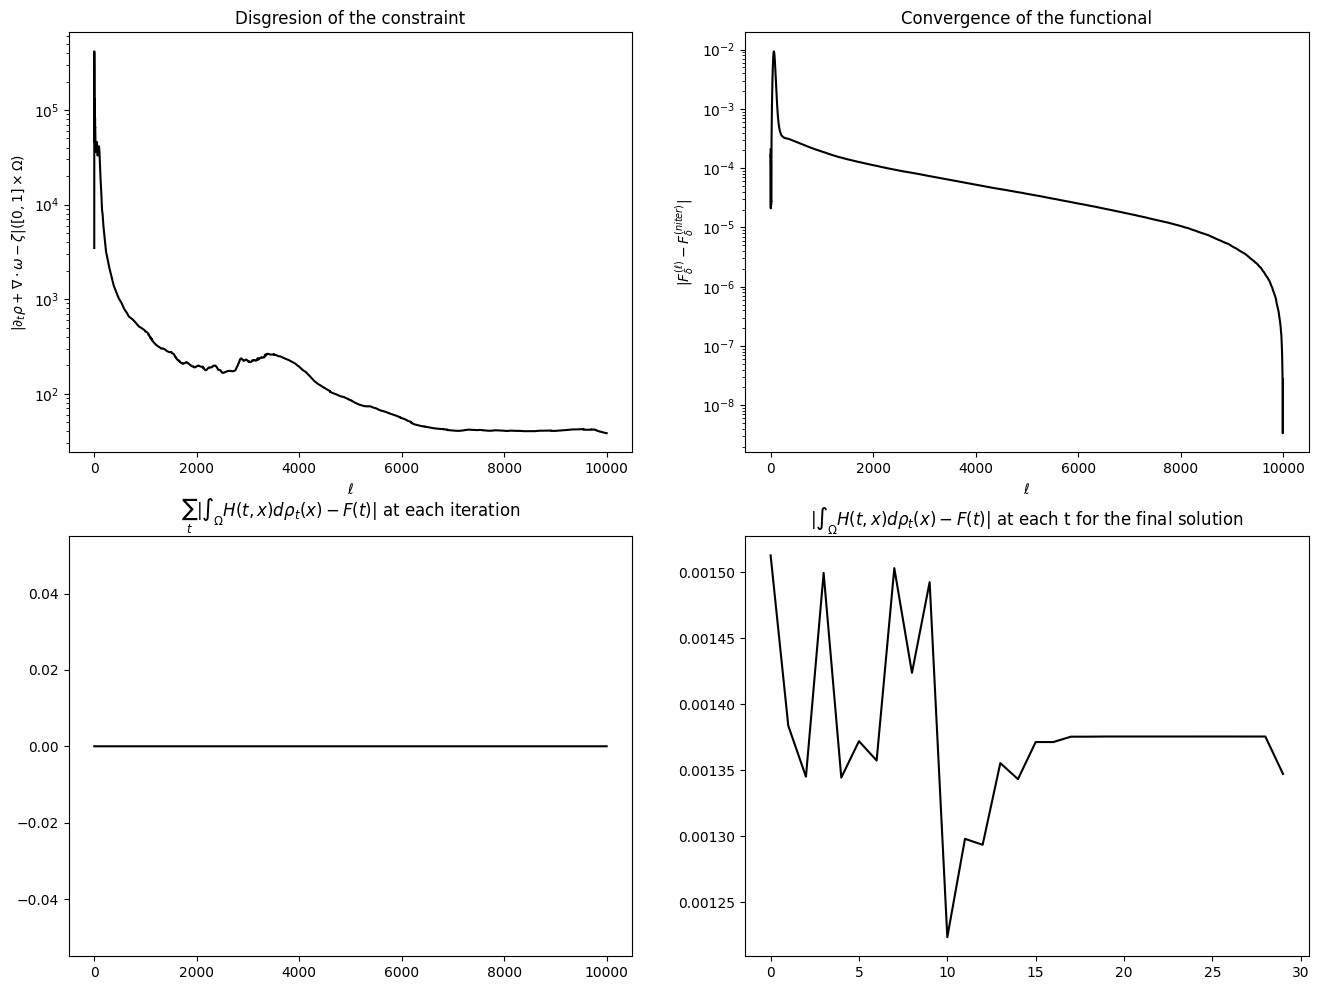

In [27]:
convergence_plots(lists, x, H, F, math.prod(dx))